<div class="alert alert-block alert-info">
<h2> Comments </h2>
</div>

Hi Jing,

I have checked you work and left comments in such cells. Cells are of two types:

<div class="alert alert-block alert-danger">
<p> <strong> A red colored cell </strong> indicates that you need to improve or adjust part of the project above. </p>
</div>
<div class="alert alert-block alert-info">
<p> <strong> A blue colored cell </strong> indicates that no improvements are needed in the cells above. May include some suggestions and recommendations.</p>
</div>

Hope it all will be clear to you :)

You did a good job 😀. You  understand what you are doing and why, also can make right conclusions - which is great 👍.

Thank you for your explanations :)

The project is accepted :)

*Good luck!*

------------

# Background Information
You work as an analyst for "Megaline", a state mobile operator. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department would like to know which of the plans is more profitable in order to adjust the advertising budget.

You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 "Megaline" clients, specifically, who the clients are, where they are from, which plan they use, the number of calls made and SMS they sent in 2018. You have to analyse clients' behavior and work out the most profitable prepaid plan.

### Prepaid Plans Description
Surf
1.	Monthly charge: \\$20
2.	500 monthly minutes, 50 SMS and 15 GB of web traffic
3.	After exceeding the package limits: 
    1. 1 minute: 3 cents ("Megaline" always rounds up the minute and megabyte values. If the call lasted just one second, it will be counted as one minute); 
    2. SMS: 3 cents; 
    3. 1 GB of web traffic: \\$10.

Ultimate
1.	Monthly charge: 70 dollar
2.	3000 monthly minutes, 1000 SMS and 30 GB of web traffic
3.	After exceeding the package limits: 
    1. 1 minute: 1 cent; 
    2. SMS: 1 cent; 
    3. 1 GB of web traffic: \\$7.



# Step 1. Open the data file and study the general information

In [1]:
# import libraries

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
pd.pandas.set_option('display.max_columns', None)

In [2]:
# import datasets

call = pd.read_csv('/datasets/megaline_calls.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')
sms = pd.read_csv('/datasets/megaline_messages.csv')
plan = pd.read_csv('/datasets/megaline_tariffs.csv')
user = pd.read_csv('/datasets/megaline_users.csv')

print(call.shape)
print(internet.shape)
print(sms.shape)
print(plan.shape)
print(user.shape)

(137735, 4)
(104825, 4)
(76051, 3)
(2, 8)
(500, 8)


### Prepare for a series of transactional datasets

In [3]:
# use the 'user' dataset as our base table, and create a column to represent the days has passed since first registration

user['current_date'] = pd.datetime.now().date()
user['current_date'] = pd.to_datetime(user['current_date'], format='%Y-%m-%d')
user['reg_date'] = pd.to_datetime(user['reg_date'], format='%Y-%m-%d')
user['days_passed'] = (user['current_date'] - user['reg_date']).dt.days
user.drop(columns=['current_date','reg_date'], inplace=True)

# sms transactional dataset

user_sms = user.merge(sms)
user_sms['sms_id'] = user_sms['id']
user_sms.drop(columns='id', inplace=True)

# internet transactional dataset

user_internet = user.merge(internet)
user_internet['session_id'] = user_internet['id']
user_internet.drop(columns='id', inplace=True)

# calls transactional dataset

user_call = user.merge(call)
user_call['call_id'] = user_call['id']
user_call.drop(columns='id', inplace=True)

### Summary
- Here I noticed that there are multiple dataset given and they store different aspects of the information (call, sms, internet).
- Intuitively thinking, we would need to join them in certain way. However, having looked at the shape of all datasets, we are confident to say the datasets can not be joined directly since they all have different dimensions. 
- I decided to use the 'user' table as a base table table since it has the most tidy format. The approach I choose is to prepare trasaction datasets first, then aggregate them in certain way so that each line record represent one person.
- Eventually, append these transactional dataset to the base table to expend the dimension of information that it captures.
- Transactional dataset is good for intermediate analysis (ad-hoc), such as using it to create pivot tables to provide quick statistics. While an anlytical dataset would be ideal, because of it's tidy format, to study population's true charateristics. 

<div class="alert alert-block alert-info">
<h2> Comments </h2>
</div>

Great :)

------------

# Step 2. Prepare the data

### Preprocessing
- Convert the data to the necessary types
- Find and remove the errors in the data

In [4]:
# convert id columns for each transactional dataset to integer

user_call['user_id'] = user_call['user_id'].astype('int')
user_internet['user_id'] = user_internet['user_id'].astype('int')
user_sms['user_id'] = user_sms['user_id'].astype('int')

In [5]:
# investigate the important numerical fields for internet use and making phone calls

print(len(user_call.query('duration == 0')))
print(len(user_internet.query('mb_used == 0')))

# fillin the 0 mb and 0 durations with medians

user_call.loc[user_call['duration'] == 0, 'duration'] = user_call['duration'].median()
user_internet.loc[user_internet['mb_used'] == 0, 'mb_used'] = user_internet['mb_used'].median()

# check for NA's

print([var for var in user_sms.drop(columns='churn_date').columns if user_sms[var].isnull().sum()>1])
print([var for var in user_internet.drop(columns='churn_date').columns if user_internet[var].isnull().sum()>1])
print([var for var in user_call.drop(columns='churn_date').columns if user_call[var].isnull().sum()>1])

26834
13747
[]
[]
[]


In [6]:
# preprocess time variables

user_sms['sms_month'] = pd.to_datetime(user_sms['message_date'], format='%Y-%m-%d').dt.month
user_internet['session_month'] = pd.to_datetime(user_internet['session_date'], format='%Y-%m-%d').dt.month
user_call['call_month'] = pd.to_datetime(user_call['call_date'], format='%Y-%m-%d').dt.month

In [7]:
# look for duplicates

print(user_call.duplicated().sum())
print(user_internet.duplicated().sum())
print(user_sms.duplicated().sum())

0
0
0


### Summary
- All datasets' identifier field are converted to integer.
- New 'sms_month', 'call_month', etc. are created to represent the month that a user made each phone, sms and internet session, the month information will be needed when creating pivot tables.
- It's found that there are 0 durations and 0 mbs in the call transaction data and internet transaction data. This does make sense because the representaion of a record in those datasets indicates that there is a phone call being made or a internet session started. If a user did not use any internet or make any phone calls, then that user id would not appear in the call/internet transaction data at all.
- I replaced all the 0 call minutes and internet sessions with the median of each group.
- There is no duplicated data and no missing values overall.

<div class="alert alert-block alert-info">
<h2> Comments </h2>
</div>

Okay :)


Please keep in mind 2 things that skewed up your analysis:
1. Zero duration calls can appear because, for example, client called but didn't get a respond from the other side. So, the length of the call results in zero. The same thing for internet. It may be that client connected to the internet but used just a few bytes that resulted in 0.00 Mbytes due to rounding. Thus, filling nulls with median values increases real profit of the company :(

2. By changing data type from float to int you just get rid of the float part and stay with the integer part of the value. If you want to round value to the closest integer, for example, you need to use `round()` function. Here it is very important to round all values up, because it is company's policy and buy getting rid of the float part you just cut consumption and company's real profit.

------------

### Prepare for a analytical dataset
For each user, find:
- The number of calls made and minutes spent per month;
- The number of SMS sent per month;
- The volume of web traffic per month;
- The monthly profit from each of the users (subtract free package limit from the total number of calls, SMS and web traffic; multiply the result by plan's additional charge; add monthly charge depending on the calling plan).

In [8]:
# create pivot tables

user_call_pivot = user_call.pivot_table(index=['user_id', 'call_month'], values='duration', aggfunc=['count', 'sum'])
user_sms_pivot = user_sms.pivot_table(index=['user_id', 'sms_month'], values='sms_id', aggfunc='count')
user_internet_pivot = user_internet.pivot_table(index=['user_id', 'session_month'], values='mb_used', aggfunc='sum')

# change column names

user_call_pivot.columns = ['num_calls', 'total_duration']
user_sms_pivot.columns = ['total_sms']
user_internet_pivot.columns = ['total_mb']

# convert multi-index to columns

user_call_pivot.reset_index(drop=False, inplace=True)
user_sms_pivot.reset_index(drop=False, inplace=True)
user_internet_pivot.reset_index(drop=False, inplace=True)

# add plan info

user_call_pivot = user_call_pivot.merge(user)
user_sms_pivot = user_sms_pivot.merge(user)
user_internet_pivot = user_internet_pivot.merge(user)

In [9]:
# calculate profits for addtional call minutes (unit: dollar, level: monthly)

def call_profit(row):
    x = row['tariff']
    y = row['duration_left']
    if x == 'ultimate':
        if y > 0:
            return y*0.01
        else:
            return 0
    if x == 'surf':
        if y > 0:
            return y*0.03
        else:
            return 0

user_call_pivot['duration_left'] = np.ceil(user_call_pivot.query('tariff == "ultimate"')['total_duration'] - 3000)
user_call_pivot.loc[user_call_pivot['duration_left'].isnull(), 'duration_left'] = np.ceil(user_call_pivot.query('tariff == "surf"')['total_duration'] - 500)
user_call_pivot['call_profit'] = user_call_pivot.apply(call_profit, axis=1)
print([var for var in user_call_pivot.drop(columns='churn_date').columns if user_call_pivot[var].isnull().sum()>1]) # check NA's

# calculate profits for additional internet (unit: dollar, level: monthly)

def gb_profit(row):
    x = row['tariff']
    y = row['gb_left']
    if x == 'ultimate':
        if y > 0:
            return y*7
        else:
            return 0
    if x == 'surf':
        if y > 0:
            return y*10
        else:
            return 0

user_internet_pivot['mb_left'] = user_internet_pivot.query('tariff == "ultimate"')['total_mb'] - 30000
user_internet_pivot.loc[user_internet_pivot['mb_left'].isnull(), 'mb_left'] = user_internet_pivot.query('tariff == "surf"')['total_mb'] - 15000
user_internet_pivot['gb_left'] = user_internet_pivot['mb_left'] / 1000 # converts to gb
user_internet_pivot['gb_profit'] = user_internet_pivot.apply(gb_profit, axis=1)
print([var for var in user_internet_pivot.drop(columns='churn_date').columns if user_internet_pivot[var].isnull().sum()>1]) # check NA's

# calculate profits for additional message (unit: dollar, level: monthly)

def sms_profit(row):
    x = row['tariff']
    y = row['sms_left']
    if x == 'ultimate':
        if y > 0:
            return y*0.01
        else:
            return 0
    if x == 'surf':
        if y > 0:
            return y*0.03
        else:
            return 0

user_sms_pivot['sms_left'] = user_sms_pivot.query('tariff == "ultimate"')['total_sms'] - 1000
user_sms_pivot.loc[user_sms_pivot['sms_left'].isnull(), 'sms_left'] = user_sms_pivot.query('tariff == "surf"')['total_sms'] - 50
user_sms_pivot['sms_profit'] = user_sms_pivot.apply(sms_profit, axis=1)
print([var for var in user_sms_pivot.drop(columns='churn_date').columns if user_sms_pivot[var].isnull().sum()>1]) # check NA's

[]
[]
[]


In [10]:
# expend the 'user' dataset to include profit data
# profit unit: dollar 
# profit level: annual, monthly

temp1 = user_call_pivot.groupby('user_id')['call_profit'].sum()
temp2 = user_internet_pivot.groupby('user_id')['gb_profit'].sum()
temp3 = user_sms_pivot.groupby('user_id')['sms_profit'].sum()

user = user.join(temp1, on='user_id')
user = user.join(temp2, on='user_id')
user = user.join(temp3, on='user_id')
del temp1, temp2, temp3

user['call_profit'].fillna(value = 0, inplace=True)
user['gb_profit'].fillna(value = 0, inplace=True)
user['sms_profit'].fillna(value = 0, inplace=True)

user['annual_profit'] = user.query('tariff == "ultimate"')[['call_profit','gb_profit','sms_profit']].apply(sum, axis=1) + (70*12)
user.loc[user['annual_profit'].isnull(), 'annual_profit'] = user.query('tariff == "surf"')[['call_profit','gb_profit','sms_profit']].apply(sum, axis=1) + (20*12)
user['monthly_profit'] = user['annual_profit'] / 12

print([var for var in user.drop(columns='churn_date').columns if user[var].isnull().sum()>1]) # check NA's

[]


In [11]:
# expend the 'user' dataset to include monthly data useage for each user

temp1 = user_call_pivot.groupby('user_id')[['total_duration', 'num_calls']].sum()
temp2 = user_internet_pivot.groupby('user_id')['total_mb'].sum()
temp3 = user_sms_pivot.groupby('user_id')['total_sms'].sum()

user = user.join(temp1, on='user_id')
user = user.join(temp2, on='user_id')
user = user.join(temp3, on='user_id')
del temp1, temp2, temp3

user['total_duration'].fillna(value = 0, inplace=True)
user['num_calls'].fillna(value = 0, inplace=True)
user['total_mb'].fillna(value = 0, inplace=True)
user['total_sms'].fillna(value = 0, inplace=True)

user['monthly_duration'] = user['total_duration'] / 12
user['monthly_calls'] = user['num_calls'] / 12
user['monthly_mb'] = user['total_mb'] / 12
user['monthly_sms'] = user['total_sms'] / 12

print([var for var in user.drop(columns='churn_date').columns if user[var].isnull().sum()>1]) # check NA's

[]


In [12]:
user.head()

,user_id,first_name,last_name,age,city,tariff,churn_date,days_passed,call_profit,gb_profit,sms_profit,annual_profit,monthly_profit,total_duration,num_calls,total_mb,total_sms,monthly_duration,monthly_calls,monthly_mb,monthly_sms
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate,NaN,448,0.00,0.0000,0.00,840.0000,70.000000,116.83,16.0,2245.45,11.0,9.735833,1.333333,187.120833,0.916667
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",surf,NaN,581,0.00,241.8217,0.09,481.9117,40.159308,1993.28,261.0,92477.24,207.0,166.106667,21.750000,7706.436667,17.250000
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",surf,NaN,512,0.00,113.0888,0.00,353.0888,29.424067,890.75,113.0,49924.77,88.0,74.229167,9.416667,4160.397500,7.333333
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",surf,NaN,778,21.81,123.8812,0.00,385.6912,32.140933,1226.38,149.0,27388.12,50.0,102.198333,12.416667,2282.343333,4.166667
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",surf,NaN,663,0.21,651.0042,0.00,891.2142,74.267850,3001.67,370.0,177679.57,177.0,250.139167,30.833333,14806.630833,14.750000


In [13]:
user.describe()

,user_id,age,days_passed,call_profit,gb_profit,sms_profit,annual_profit,monthly_profit,total_duration,num_calls,total_mb,total_sms,monthly_duration,monthly_calls,monthly_mb,monthly_sms
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,1249.500000,45.486000,630.312000,8.357460,178.581867,0.661860,620.801187,51.733432,2179.23516,275.47000,86338.913540,152.102000,181.602930,22.955833,7194.909462,12.675167
std,144.481833,16.972269,104.997427,20.050548,269.991645,2.316932,298.847517,24.903960,1901.56179,239.94608,68084.111413,187.988177,158.463482,19.995507,5673.675951,15.665681
min,1000.000000,18.000000,441.000000,0.000000,0.000000,0.000000,240.000000,20.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1124.750000,30.000000,542.750000,0.000000,0.000000,0.000000,340.994150,28.416179,708.65750,91.50000,29149.770000,14.000000,59.054792,7.625000,2429.147500,1.166667
50%,1249.500000,46.000000,635.000000,0.000000,56.486295,0.000000,596.583450,49.715287,1627.54000,209.50000,69443.100000,87.000000,135.628333,17.458333,5786.925000,7.250000
75%,1374.250000,61.000000,721.250000,7.755000,263.098650,0.000000,840.000000,70.000000,3200.89750,407.25000,130664.547500,225.000000,266.741458,33.937500,10888.712292,18.750000
max,1499.000000,75.000000,805.000000,176.010000,1687.102800,24.360000,1947.292800,162.274400,10361.56000,1300.00000,399446.810000,1288.000000,863.463333,108.333333,33287.234167,107.333333


### Summary
- First, create pivot tables for the users who did show up in our transactional dataset and calculate their total data usage for the month if they make any phone calls, sms, and/or internet sessions.
- Next, determine whether their usage exceeds the monthly plan limits. Then calculate charges for their additional usage. 
- Lastly, append users' annual/monthly charges along with their montly data usage to the user table.

<div class="alert alert-block alert-info">
<h2> Comments </h2>
</div>

Great :)

------------

# Step 3. Analyze the data
Describe the clients' behavior. For the users from each plans:
- Find the number of minutes and SMS and the volume of web traffic they require per month. 
- Calculate the mean, dispersion and standard deviation. 
- Plot histograms. 
- Describe the distributions.

In [14]:
# for each population, calculate the mean, variance, and standard deviation from users' monthly usage data

print('For ultimate plan users, the monthly average call usage is:', round(user.query('tariff == "ultimate"')['monthly_duration'].mean(),0),'minutes')
print('For ultimate plan users, the monthly average call usage is:', round(user.query('tariff == "ultimate"')['monthly_calls'].mean(),0),'calls')
print('For ultimate plan users, the monthly average mb usage is:', round(user.query('tariff == "ultimate"')['monthly_mb'].mean(),0),'mb')
print('For ultimate plan users, the monthly average sms usage is:', round(user.query('tariff == "ultimate"')['monthly_sms'].mean(),0),'sms','\n')

print('For ultimate plan users, the call usage variance is:', round(np.var(user.query('tariff == "ultimate"')['monthly_duration']),0),'minutes')
print('For ultimate plan users, the call usage variance is:', round(np.var(user.query('tariff == "ultimate"')['monthly_calls']),0),'calls')
print('For ultimate plan users, the mb usage variance is:', round(np.var(user.query('tariff == "ultimate"')['monthly_mb']),0),'mb')
print('For ultimate plan users, the sms usage variance is:', round(np.var(user.query('tariff == "ultimate"')['monthly_sms']),0),'sms','\n')

print('For ultimate plan users, the call usage std is:', round(np.std(user.query('tariff == "ultimate"')['monthly_duration']),0),'minutes')
print('For ultimate plan users, the call usage std is:', round(np.std(user.query('tariff == "ultimate"')['monthly_calls']),0),'calls')
print('For ultimate plan users, the mb usage std is:', round(np.std(user.query('tariff == "ultimate"')['monthly_mb']),0),'mb')
print('For ultimate plan users, the sms usage std is:', round(np.std(user.query('tariff == "ultimate"')['monthly_sms']),0),'sms','\n')

print('For surf plan users, the monthly average call usage is:', round(user.query('tariff == "surf"')['monthly_duration'].mean(),0),'minutes')
print('For surf plan users, the monthly average call usage is:', round(user.query('tariff == "surf"')['monthly_calls'].mean(),0),'calls')
print('For surf plan users, the monthly average mb usage is:', round(user.query('tariff == "surf"')['monthly_mb'].mean(),0),'mb')
print('For surf plan users, the monthly average sms usage is:', round(user.query('tariff == "surf"')['monthly_sms'].mean(),0),'sms', '\n')

print('For surf plan users, the call usage variance is:', round(np.var(user.query('tariff == "surf"')['monthly_duration']),0),'minutes')
print('For surf plan users, the call usage variance is:', round(np.var(user.query('tariff == "surf"')['monthly_calls']),0),'calls')
print('For surf plan users, the mb usage variance is:', round(np.var(user.query('tariff == "surf"')['monthly_mb']),0),'mb')
print('For surf plan users, the sms usage variance is:', round(np.var(user.query('tariff == "surf"')['monthly_sms']),0),'sms','\n')

print('For surf plan users, the call usage std is:', round(np.std(user.query('tariff == "surf"')['monthly_duration']),0),'minutes')
print('For surf plan users, the call usage std is:', round(np.std(user.query('tariff == "surf"')['monthly_calls']),0),'calls')
print('For surf plan users, the mb usage std is:', round(np.std(user.query('tariff == "surf"')['monthly_mb']),0),'mb')
print('For surf plan users, the sms usage std is:', round(np.std(user.query('tariff == "surf"')['monthly_sms']),0),'sms')

For ultimate plan users, the monthly average call usage is: 178.0 minutes
For ultimate plan users, the monthly average call usage is: 23.0 calls
For ultimate plan users, the monthly average mb usage is: 7170.0 mb
For ultimate plan users, the monthly average sms usage is: 14.0 sms 

For ultimate plan users, the call usage variance is: 24787.0 minutes
For ultimate plan users, the call usage variance is: 398.0 calls
For ultimate plan users, the mb usage variance is: 35667821.0 mb
For ultimate plan users, the sms usage variance is: 272.0 sms 

For ultimate plan users, the call usage std is: 157.0 minutes
For ultimate plan users, the call usage std is: 20.0 calls
For ultimate plan users, the mb usage std is: 5972.0 mb
For ultimate plan users, the sms usage std is: 16.0 sms 

For surf plan users, the monthly average call usage is: 183.0 minutes
For surf plan users, the monthly average call usage is: 23.0 calls
For surf plan users, the monthly average mb usage is: 7207.0 mb
For surf plan user

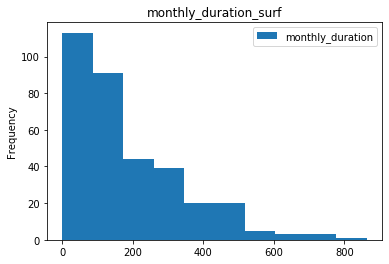

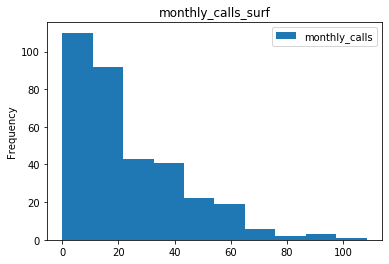

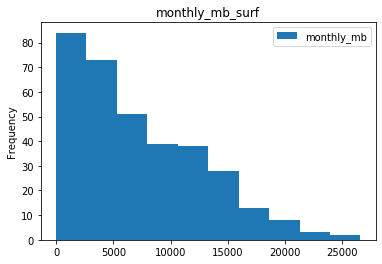

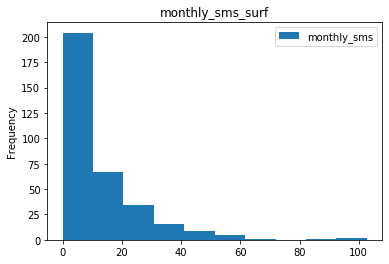

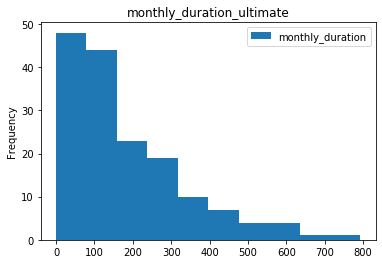

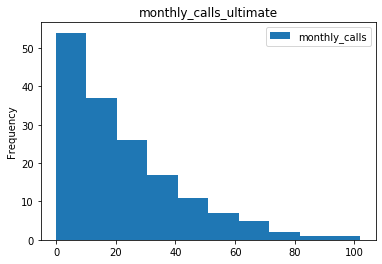

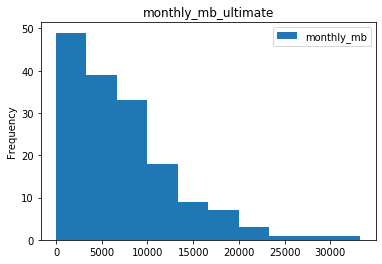

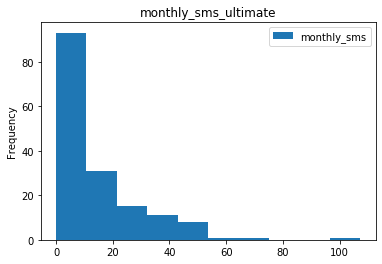

In [15]:
# plot histograms for each population

for name, group_data in user.groupby('tariff'):
    for each in ['monthly_duration', 'monthly_calls', 'monthly_mb', 'monthly_sms']:
        group_data.plot(y=each, title=each+'_'+name, kind='hist')

### Summary
- For the ultimate plan users:
    - The average call duration is 178 minutes per month.
    - The average number of call made is 23 calls per month.
    - The average volume of internet traffic is 7170 mb per month.
    - The average number of sms usage is 14 per month.
- For the surf plan users:
    - The average call duration is 183 minutes per month.
    - The average call usage is 23.0 calls per month.
    - The average mb usage is 7207.0 mb per month.
    - The average sms usage is 12.0 sms per month.
- If we look at the data usage distributions for each user:
    - All distrubtions are Poisson distribution with a low lambda value
    - For Poisson distribution, the lambda value equals to the corrosponding variable and also its variance.

<div class="alert alert-block alert-info">
<h2> Comments </h2>
</div>

Great :)

It would be better to plot corresponding values for 2 plans on the same graph. It would make it easier to compare these plans. 

------------

# Step 4. Test the hypotheses
- The average profit from the users of Ultimate and Surf calling plans is different;
- The average profit from the users in NY-NJ area is different from that of the users from other regions.
- Explain how you formulated the null and alternative hypotheses;
- Explain what criterion you used for testing the hypotheses and why.

In [16]:
# test for equal variance

temp1 = user.query('tariff == "ultimate"')['monthly_profit']
temp2 = user.query('tariff == "surf"')['monthly_profit']

F = np.var(temp1) / np.var(temp2)
df1,df2 = len(temp1) - 1, len(temp2) - 1
p_value = st.f.cdf(F, df1, df2)
alpha = 0.05

if p_value > alpha:
    print('Failed to reject the null hypothesis, hence Var(ultimate) == Var(surf)', '\n')
else:
    print('Have sufficient significance to reject the null hypothesis, hence Var(ultimate) != Var(surf)', '\n')

# hpothesis testing - average profit (monthly) of all users from each plan

results = st.ttest_ind(temp1, temp2, equal_var=False)
print('p-value:', results.pvalue)
if results.pvalue < alpha:
      print('Have sufficient significance to reject the null hypothesis, hence the avg profits for two population are different')
else:
      print('Failed to reject the null hypothesis, hence the avg profits of two population is the same')
del temp1, temp2

Have sufficient significance to reject the null hypothesis, hence Var(ultimate) != Var(surf) 

p-value: 1.733800040208871e-62
Have sufficient significance to reject the null hypothesis, hence the avg profits for two population are different


In [17]:
# find NY-NJ area 

pattern = re.compile(r'\b[A-Z]{2}\b')
state = []

for each in user['city']:
    temp = pattern.findall(each)
    state.append(temp)

temp = pd.DataFrame.from_records(state)
user = pd.concat([user, temp], axis=1)
user.rename(columns={0:'state1', 1:'state2', 2:'state3', 3:'state4'}, inplace=True)
del temp

In [18]:
# test for equal variance

temp1 = user.query('state1 == "NY" and state2 == "NJ"')['monthly_profit']
temp2 = user.loc[user.index.difference(temp1.index), 'monthly_profit']

F = np.var(temp1) / np.var(temp2)
df1,df2 = len(temp1) - 1, len(temp2) - 1
p_value = st.f.cdf(F, df1, df2)
alpha = 0.05

if p_value > alpha:
    print('Failed to reject the null hypothesis, hence Var(ultimate) == Var(surf)', '\n')
else:
    print('Have sufficient significance to reject the null hypothesis, hence Var(ultimate) != Var(surf)', '\n')
    
# hypothesis testing for equal avg profit 

results = st.ttest_ind(temp1, temp2, equal_var=True)
print('p-value:', results.pvalue)
if results.pvalue < alpha:
      print('Have sufficient significance to reject the null hypothesis, hence the avg profits for two population are different')
else:
      print('Failed to reject the null hypothesis, hence the avg profits of two population is the same')
del temp1, temp2

Failed to reject the null hypothesis, hence Var(ultimate) == Var(surf) 

p-value: 0.8139507320977057
Failed to reject the null hypothesis, hence the avg profits of two population is the same


<div class="alert alert-block alert-info">
<h2> Comments </h2>
</div>

Great :)

It is really good that you checked equality of variances.

You need to state null hypothesis :)

------------

### Summary
- Ultimate plan customers vs. Surf plan customers
    - Null: The average profit from the ultimate plan users and from surf plan users is the same;
    - Alternative: The average profit from the ultimate plan users and from surf plan users is different.
    - Significance level: 5%, meaning that we accept a 5% risk of of concluding that a difference exists when there is no actual difference.
- NY-NJ customers vs. Other area customers
    - Null: The average profit from the users in NY-NJ area is the same as that of the users from other regions.
    - Alternative: The average profit from the users in NY-NJ area is different from that of the users from other regions.
    - Significance level: 5%

<div class="alert alert-block alert-info">
<h2> Comments </h2>
</div>

Great :)

------------